In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import dynamo as dyn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from graphvelo.plot import gene_trend
from graphvelo.graph_velocity import GraphVelo

import warnings
warnings.simplefilter("ignore")

/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read(('adata_gv.h5ad'))
adata

AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'palantir', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score'
    uns: 'clusters_colors', 'gv_params', 'log1p', 'neighbors', 'palantir_branch_probs_cell_types', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'MAGIC_imputed_data', 'X_pca', 'X_tsne', 'gv_pca', 'gv_tsne', 'palantir_branch_probs'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau'

In [3]:
bdata = adata.copy()
gv = GraphVelo(bdata)
bdata.layers['velocity_u'] = gv.project_velocity(bdata.layers['Mu'], bdata.obsp['gv'])
bdata.layers['velocity'] = bdata.layers['velocity_gv'].copy()

projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:01<00:00, 4376.17it/s]


In [4]:
dyn.tl.scv_dyn_convertor(bdata)
for layer in ['M_s', 'M_u', 'velocity_U', 'velocity_S']:
    bdata.layers[layer] = sp.csr_matrix(bdata.layers[layer])

|-----> Dynamo and scvelo have different preprocessing procedures and velocity estimation methods. The conversion of adata may not be optimal for every use case, requiring potential manual adjustments.
|-----> Start converting Scvelo adata into Dynamo adata...
|-----> Scvelo data wil be converted into Dynamo adata with the conventional assumption and thestochastic model. If this is not what you want, please change them manually.


In [5]:
def plot_gamma_on_phase(adata, gene, colorby='gamma', basis='phase', cmap='viridis', ax=None):
    valid_ind = np.logical_and(adata[:, gene].layers['Mu']>0, adata[:, gene].layers['Ms']>0)
    bdata = adata[:].copy()
    if basis == 'phase':
        x_axis = bdata[:, gene].layers['Ms'].flatten()
        y_axis = bdata[:, gene].layers['Mu'].flatten()
    else:
        x_axis = bdata.obsm['X_tsne'][:, 0]
        y_axis = bdata.obsm['X_tsne'][:, 1]
    if colorby == 'gamma':
        gamma = ((bdata[:, gene].layers['Mu'] - bdata[:, gene].layers['velocity_gv']) / bdata[:, gene].layers['Ms']).flatten()
        gamma[np.isinf(gamma)] = 0
        gamma[np.isnan(gamma)] = 0
        bdata.obs['tmp'] = gamma
    else:
        bdata.obs['tmp'] = bdata.obs[colorby].copy()
    ax = dyn.pl.scatters(
        bdata,
        vmin=10,
        vmax=90,
        color='tmp',
        basis='tsne',
        cmap=cmap,
        frontier=True,
        sort="abs",
        alpha=0.1,
        pointsize=0.1,
        x=x_axis,
        y=y_axis,
        despline=True,
        save_show_or_return="return",
        despline_sides=["right", "top"],
        deaxis=False,
        ax=ax
    )
    ax.set_title(f"{gene} gamma")
    if basis == 'phase':
        ax.set_xlabel('spliced')
        ax.set_ylabel('unspliced')
    else: 
        ax.set_xlabel('TSNE1')
        ax.set_ylabel('TSNE2')
    bdata.obs.pop('tmp')

In [6]:
def plot_alpha_on_phase(adata, gene, colorby='alpha', basis='phase', cmap='viridis', ax=None):
    valid_ind = np.logical_and(adata[:, gene].layers['Mu']>0, adata[:, gene].layers['Ms']>0)
    bdata = adata[:].copy()
    if basis == 'phase':
        x_axis = bdata[:, gene].layers['Ms'].flatten()
        y_axis = bdata[:, gene].layers['Mu'].flatten()
    else:
        x_axis = bdata.obsm['X_tsne'][:, 0]
        y_axis = bdata.obsm['X_tsne'][:, 1]
    if colorby == 'alpha':
        alpha = (bdata[:, gene].layers['Mu'] + bdata[:, gene].layers['velocity_u']).flatten()
        alpha[np.isinf(alpha)] = 0
        alpha[np.isnan(alpha)] = 0
        bdata.obs['tmp'] = alpha
    else:
        bdata.obs['tmp'] = bdata.obs[colorby].copy()
    ax = dyn.pl.scatters(
        bdata,
        vmin=10,
        vmax=90,
        color='tmp',
        basis='tsne',
        cmap=cmap,
        frontier=True,
        sort="abs",
        alpha=0.1,
        pointsize=0.1,
        x=x_axis,
        y=y_axis,
        despline=True,
        save_show_or_return="return",
        despline_sides=["right", "top"],
        deaxis=False,
        ax=ax
    )
    ax.set_title(f"{gene} alpha")
    if basis == 'phase':
        ax.set_xlabel('spliced')
        ax.set_ylabel('unspliced')
    else: 
        ax.set_xlabel('TSNE1')
        ax.set_ylabel('TSNE2')
    bdata.obs.pop('tmp')

|-----------> plotting with basis key=X_tsne
|-----------> plotting with basis key=X_tsne


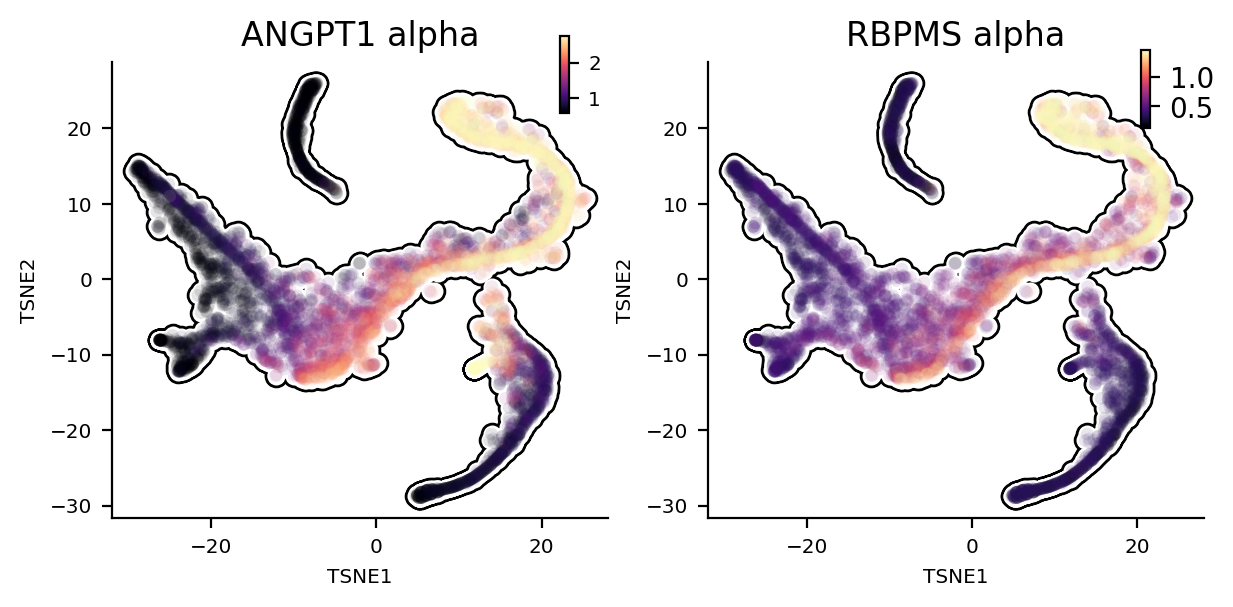

In [7]:
figure, axes = plt.subplots(1, 2, figsize=(7, 3))
plot_alpha_on_phase(adata, 'ANGPT1', basis='tsne', cmap='magma', ax=axes[0])
plot_alpha_on_phase(adata, 'RBPMS', basis='tsne', cmap='magma', ax=axes[1])
# plt.savefig('figures_sup/alpha_tsne.pdf', dpi=300, transparent=True)
plt.show()

|-----------> plotting with basis key=X_tsne
|-----------> plotting with basis key=X_tsne


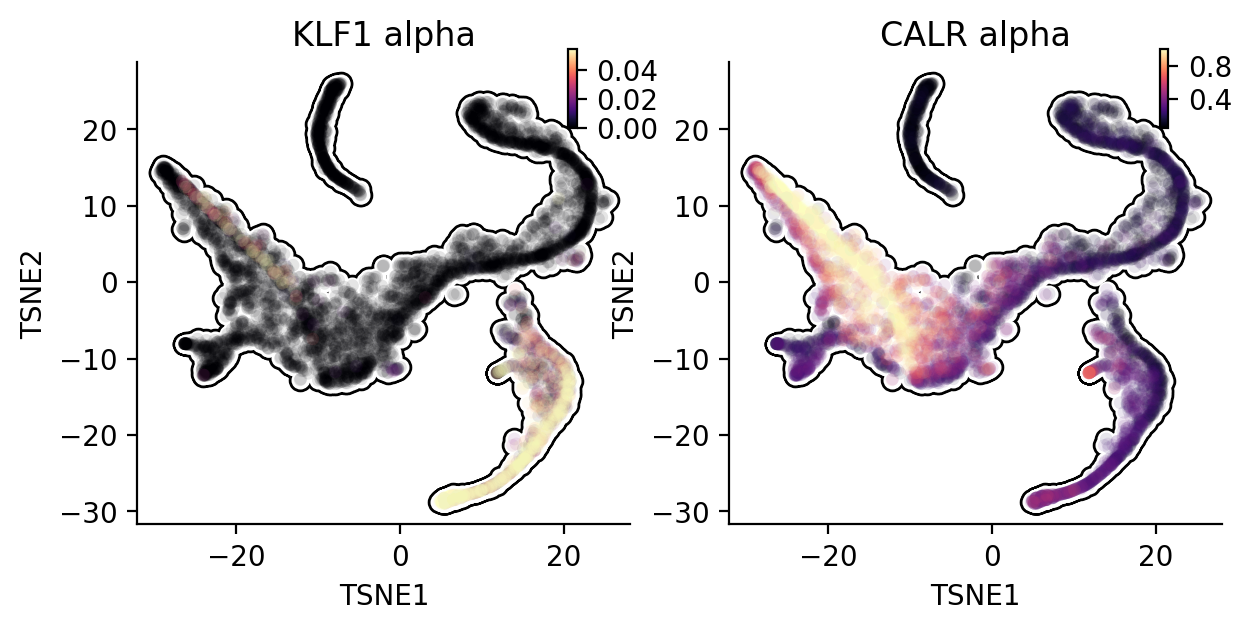

In [8]:
figure, axes = plt.subplots(1, 2, figsize=(7, 3))
plot_alpha_on_phase(adata, 'KLF1', basis='tsne', cmap='magma', ax=axes[0])
plot_alpha_on_phase(adata, 'CALR', basis='tsne', cmap='magma', ax=axes[1])
plt.show()

|-----------> plotting with basis key=X_tsne
|-----------> plotting with basis key=X_tsne


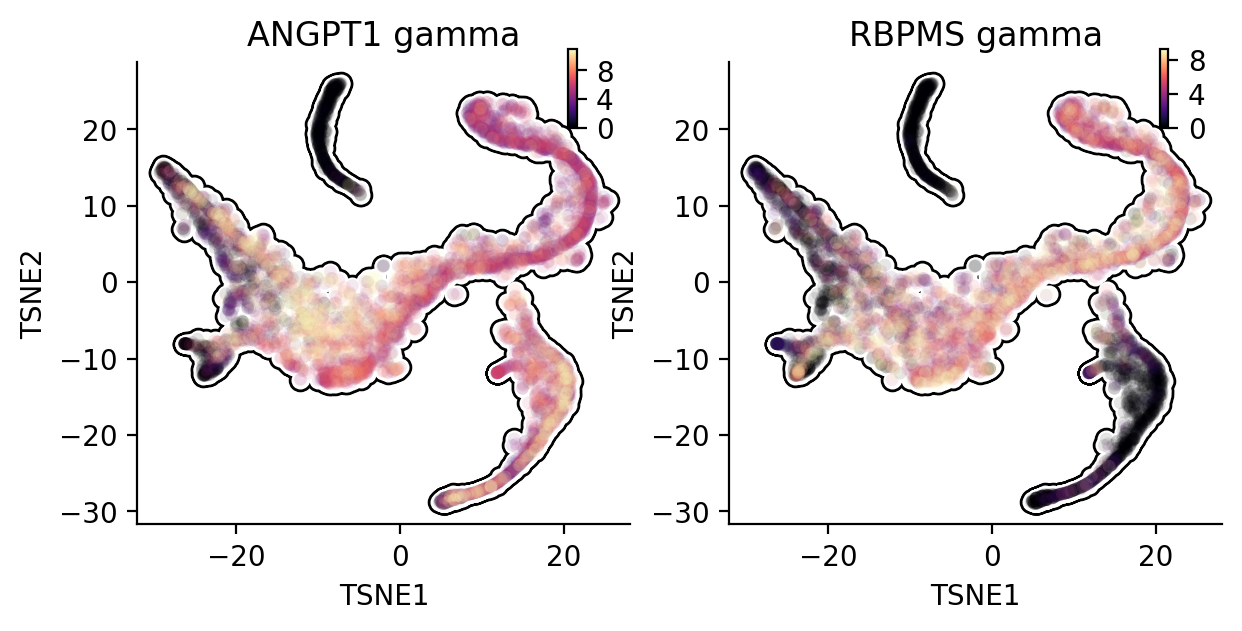

In [9]:
figure, axes = plt.subplots(1, 2, figsize=(7, 3))
plot_gamma_on_phase(adata, 'ANGPT1', basis='tsne', cmap='magma', ax=axes[0])
plot_gamma_on_phase(adata, 'RBPMS', basis='tsne', cmap='magma', ax=axes[1])
# plt.savefig('figures_sup/gamma_tsne.pdf', dpi=300, transparent=True)
plt.show()

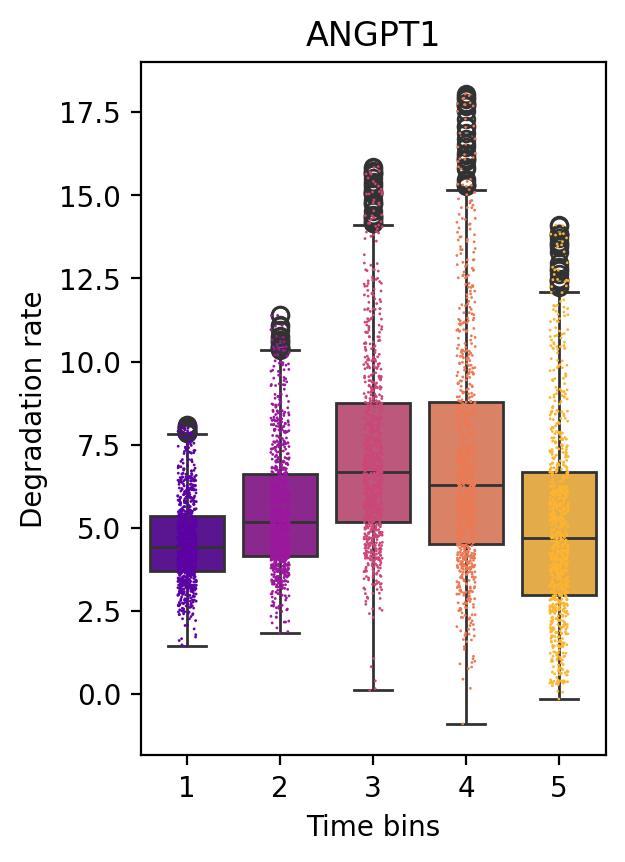

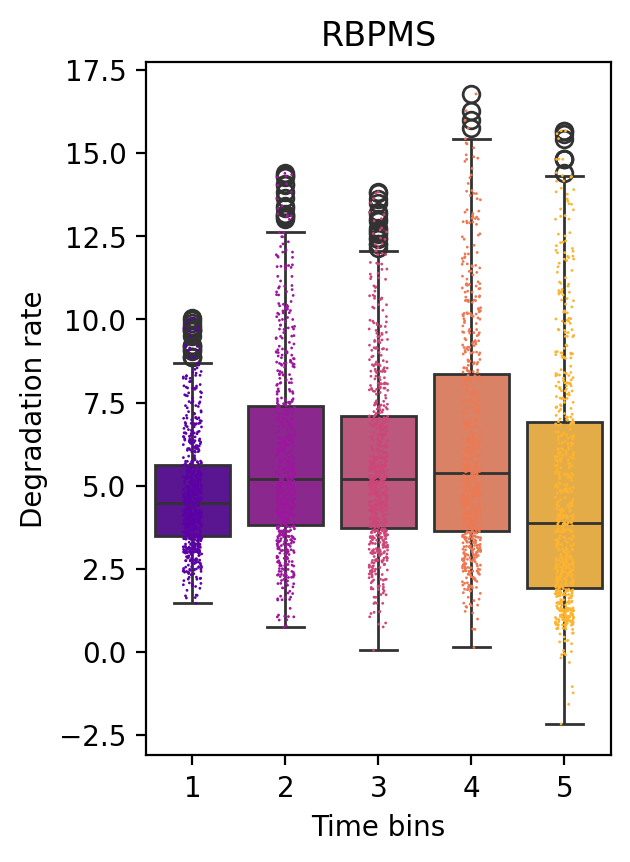

In [10]:
genes = ['ANGPT1', 'RBPMS']
num_bins=5
def remove_outliers(bin_data):
    Q1 = np.percentile(bin_data, 25)
    Q3 = np.percentile(bin_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return bin_data[(bin_data >= lower_bound) & (bin_data <= upper_bound)]

for g in genes:
    valid_ind = np.logical_and(adata[:, g].layers['Mu']>0, adata[:, g].layers['Ms']>0)
    gamma = ((adata[valid_ind, g].layers['Mu'] - adata[valid_ind, g].layers['velocity_gv']) / adata[valid_ind, g].layers['Ms']+1e-5).flatten()
    t = adata[valid_ind].obs['palantir_pseudotime']
    sorted_ind = np.argsort(t)
    bins = np.array_split(gamma[sorted_ind], num_bins)
    bins = [remove_outliers(bin) for bin in bins]
    df = pd.DataFrame({'Degradation rate': np.concatenate(bins),
                    'Bin': np.repeat(range(1, num_bins + 1), [len(bin) for bin in bins])})

    plt.figure(figsize=(3,4.5), dpi=100)
    ax = sns.stripplot(x="Bin", y="Degradation rate", data=df, marker='o', size=1, palette='plasma', legend=False)
    sns.boxplot(x='Bin', y='Degradation rate', data=df, palette='plasma', ax=ax)
    # ax.axhline(y=adata[:, g].var['fit_gamma'].values[0], color='black', linestyle='--')
    plt.xlabel('Time bins')
    plt.ylabel('Degradation rate')
    plt.title(f'{g}')
    # plt.savefig(f"figures/{g}_gamma.pdf", transparent=True, dpi=300)
    plt.show()